In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import pairwise_distances
import numpy as onp
import jax.numpy as np
from jax import jit, vmap
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as t
from ipywidgets import interact
from jax import grad
from jax.scipy.optimize import minimize
from jax.config import config
config.update("jax_enable_x64", True)
import jax
from jax.scipy.linalg import cholesky, cho_factor, cho_solve
from jax.scipy.optimize import minimize
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_box

In [15]:
import pandas as pd

In [16]:
PCANet = pd.read_csv("data/PCA_Adv.csv", header = None).to_numpy()
DeepONet = pd.read_csv("data/DeepONet_Adv.csv", header = None).to_numpy()
Para = pd.read_csv("data/PARA_Adv.csv", header = None).to_numpy()
FNO = pd.read_csv("data/FNO_Adv.csv", header = None).to_numpy()

In [17]:

# 0-> ndata points
# 1-> complexity
# 2-> complexity (flops)
# 3-> train acc
# 4-> test acc


In [18]:
Inputs = onp.load('data/Advection_inputs.npy')
Outputs = onp.load('data/Advection_outputs.npy')

Jax GP regression

In [19]:
def sqeuclidean_distances(x: np.ndarray, y: np.ndarray) -> float:
    return np.sum( (x - y) ** 2)
dists = jit(vmap(vmap(sqeuclidean_distances, in_axes=(None, 0)), in_axes=(0, None)))

def euclidean_distances(x: np.ndarray, y: np.ndarray) -> float:
    return np.sqrt(np.sum( (x - y) ** 2))
sqdists = jit(vmap(vmap(euclidean_distances, in_axes=(None, 0)), in_axes=(0, None)))


@jit
def matern(v1, v2, sigma = 50):
    #V1 is a [k1] vector
    #V2 is a [k2] vector
    #returns a k1xk2 matrix
    d = sqdists(v1, v2)
    #return a*np.exp(-d**2/sigma)
    return (1+np.sqrt(5)*d/sigma +5*d**2/(3*sigma**2))*np.exp(-np.sqrt(5)*d/sigma)

@jit
def exp(v1, v2, sigma):
    #V1 is a [k1] vector
    #V2 is a [k2] vector
    #returns a k1xk2 matrix
    d = dists(v1, v2)
    return np.exp(-d/sigma)
    #return (1+np.sqrt(5)*d/sigma +5*d**2/(3*sigma**2))*np.exp(-np.sqrt(5)*d/sigma)

@jit
def iq(v1, v2, sigma):
    #V1 is a [k1] vector
    #V2 is a [k2] vector
    #returns a k1xk2 matrix
    d = dists(v1, v2)
    #return a*np.exp(-d**2/sigma)
    #return (1+np.sqrt(5)*d/sigma +5*d**2/(3*sigma**2))*np.exp(-np.sqrt(5)*d/sigma)
    return 1/np.sqrt(d+sigma)

In [24]:
Ntrain = 10000
Xtr = Inputs.T[:Ntrain]
Ytr = Outputs.T[:Ntrain]
Xtest = Inputs.T[20000:]
Ytest = Outputs.T[20000:]


In [25]:
s = 2
nugget = 1e-8

In [26]:
def aux(kernel, s, nugget):
    k = kernel
    Kxx = k(Xtr, Xtr, s)
    nuggeted_matrix = Kxx.at[np.diag_indices_from(Kxx)].add(nugget)
    L = cho_factor(nuggeted_matrix)
    result = cho_solve(L, Ytr)
    Train_pred = Kxx@result #train predictions
    K_te_tr = k(Xtest, Xtr,s)
    Test_pred = K_te_tr@result #test predictions

    np.mean(np.linalg.norm(Ytr-Train_pred, axis = 1))

    aux1 = np.mean(np.linalg.norm(Ytr-Train_pred, axis = 1))
    aux2 = np.mean(np.linalg.norm(Train_pred-Ytr, axis = 1)/np.linalg.norm(Ytr, axis = 1))
    aux3 = np.mean(np.linalg.norm(Ytest-Test_pred, axis = 1))
    aux4 = np.mean(np.linalg.norm(Ytest-Test_pred, axis = 1)/np.linalg.norm(Ytest, axis = 1))
    print(s, nugget)
    print("\n Train error (abs): {0} \n Train error (rel): {1} \n Test error (abs): {2} \n Test error (rel): {3}".format(aux1, aux2, aux3, aux4))
    print('---')

In [27]:
for kernel in [matern]:
    for s in [50]:
        for nugget in [1e-8]:
            aux(kernel, s, nugget)

50 1e-08

 Train error (abs): 0.35807291923463913 
 Train error (rel): 0.02531957893500763 
 Test error (abs): 2.1661067761799067 
 Test error (rel): 0.1531668790210943
---


In [28]:
Inputs = onp.load('data/Advection_inputs.npy')
Outputs = onp.load('data/Advection_outputs.npy')

In [12]:
Ntrain = 20000
Xtr = Inputs.T[:Ntrain]
Ytr = Outputs.T[:Ntrain]
Xtest = Inputs.T[20000:]
Ytest = Outputs.T[20000:]


In [29]:
reg = LinearRegression(n_jobs = -1).fit(Xtr, Ytr)
Ypred = reg.predict(Xtest)
np.mean(np.linalg.norm(Ytest-Ypred, axis = 1)/np.linalg.norm(Ytest, axis = 1))

DeviceArray(0.1134178, dtype=float64)

In [27]:
import pickle

In [34]:
pickle.dump([Ytest[N], Ypred[N]], open('predAdvection.pkl', 'wb'))

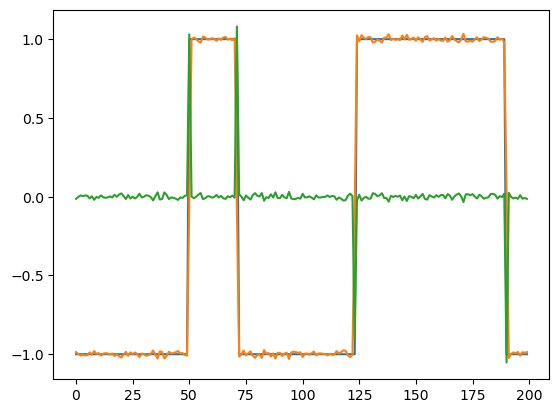

In [33]:
N = 23
plt.plot(Ytest[N])
plt.plot(Ypred[N])
plt.plot(Ytest[N]-Ypred[N])

In [30]:
#PCA

In [31]:
kernel = matern
s = 50

In [21]:
resultspca = []
for Ntrain in [20000]:
    for N_components in [16, 32, 64, 128, 200]:
        print(Ntrain)
        Ytr = Outputs.T[:Ntrain]
        Xtr = Inputs.T[:Ntrain]
        pca = PCA(n_components=min(N_components,Ntrain))
        Xtr = pca.fit_transform(Xtr)
        reg = LinearRegression(n_jobs = -1).fit(Xtr, Ytr)
        Xtest = Inputs.T[20000:]
        Ytest = Outputs.T[20000:]
        Xtest = pca.transform(Xtest)
        k = kernel
        Kxx = k(Xtr, Xtr, s)
        nuggeted_matrix = Kxx.at[np.diag_indices_from(Kxx)].add(nugget)
        L = cho_factor(nuggeted_matrix)
        result = cho_solve(L, Ytr)
        Train_pred = Kxx@result #train predictions
        K_te_tr = k(Xtest, Xtr,s)
        Test_pred = K_te_tr@result #test predictions

        np.mean(np.linalg.norm(Ytr-Train_pred, axis = 1))

        aux1 = np.mean(np.linalg.norm(Ytr-Train_pred, axis = 1))
        aux2 = np.mean(np.linalg.norm(Train_pred-Ytr, axis = 1)/np.linalg.norm(Ytr, axis = 1))
        aux3 = np.mean(np.linalg.norm(Ytest-Test_pred, axis = 1))
        aux4 = np.mean(np.linalg.norm(Ytest-Test_pred, axis = 1)/np.linalg.norm(Ytest, axis = 1))
        print(s, nugget)
        print("\n Train error (abs): {0} \n Train error (rel): {1} \n Test error (abs): {2} \n Test error (rel): {3}".format(aux1, aux2, aux3, aux4))
        print('---')       
        #resultspca.append([N_components, test_error])
#results = np.array(results)

20000
50 1e-08

 Train error (abs): 0.9288127938723734 
 Train error (rel): 0.06567698249999783 
 Test error (abs): 3.1160203409704783 
 Test error (rel): 0.22033591134154432
---
20000
50 1e-08

 Train error (abs): 0.7915690064268064 
 Train error (rel): 0.055972381222149266 
 Test error (abs): 4.750796712517089 
 Test error (rel): 0.3359320571459591
---
20000
50 1e-08

 Train error (abs): 0.654409903975152 
 Train error (rel): 0.04627376807764673 
 Test error (abs): 4.131825986233204 
 Test error (rel): 0.29216421735482934
---
20000
50 1e-08

 Train error (abs): 0.5668475200923311 
 Train error (rel): 0.0400821725356065 
 Test error (abs): 2.5386381067015407 
 Test error (rel): 0.17950882202272375
---
20000
50 1e-08

 Train error (abs): 0.5579317332513473 
 Train error (rel): 0.03945173120211915 
 Test error (abs): 2.0512991563799794 
 Test error (rel): 0.14504875437185275
---


In [32]:
#Cholesky preconditioning

In [33]:
grid = np.linspace(0,1,200)

K_i = exp(grid, grid, sigma = 10)
K_i = K_i.at[np.diag_indices_from(K_i)].add(1e-8)
L_K = cholesky(K_i, lower = True)
K_o = exp(grid, grid, sigma = 3)
K_o = K_i.at[np.diag_indices_from(K_i)].add(1e-8)
L_G = cholesky(K_i, lower = False)
L_G_inv = np.linalg.inv(L_G)


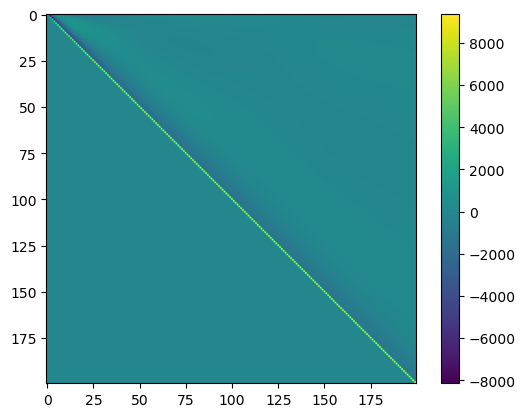

In [35]:
plt.imshow(L_G_inv)
plt.colorbar()

In [36]:
Inputs2 = L_K@Inputs
Outputs2 = Outputs

Xtr = Inputs2.T[:Ntrain]
Ytr = Outputs2.T[:Ntrain]
Xtest = Inputs2.T[20000:]
Ytest = Outputs2.T[20000:]

In [37]:
reg = LinearRegression(n_jobs = -1).fit(Xtr, Ytr)
Ypred = reg.predict(Xtest)
np.mean(np.linalg.norm(Ytest-Ypred, axis = 1)/np.linalg.norm(Ytest, axis = 1))

DeviceArray(0.11341361, dtype=float64)

In [38]:
s = 50

In [39]:
k = matern
nugget = 1e-10
Kxx = k(Xtr, Xtr, s)
nuggeted_matrix = Kxx.at[np.diag_indices_from(Kxx)].add(nugget)
L = cho_factor(nuggeted_matrix)
result = cho_solve(L, Ytr)
Train_pred = Kxx@result #train predictions
K_te_tr = k(Xtest, Xtr,s)
Test_pred = K_te_tr@result #test predictions

np.mean(np.linalg.norm(Ytr-Train_pred, axis = 1))

aux1 = np.mean(np.linalg.norm(Ytr-Train_pred, axis = 1))
aux2 = np.mean(np.linalg.norm(Train_pred-Ytr, axis = 1)/np.linalg.norm(Ytr, axis = 1))
aux3 = np.mean(np.linalg.norm(Ytest-Test_pred, axis = 1))
aux4 = np.mean(np.linalg.norm(Ytest-Test_pred, axis = 1)/np.linalg.norm(Ytest, axis = 1))
print(s, nugget)
print("\n Train error (abs): {0} \n Train error (rel): {1} \n Test error (abs): {2} \n Test error (rel): {3}".format(aux1, aux2, aux3, aux4))
print('---')

50 1e-10

 Train error (abs): 1.5176485770056702 
 Train error (rel): 0.10731396002588238 
 Test error (abs): 1.6460050366791292 
 Test error (rel): 0.11639013233030239
---


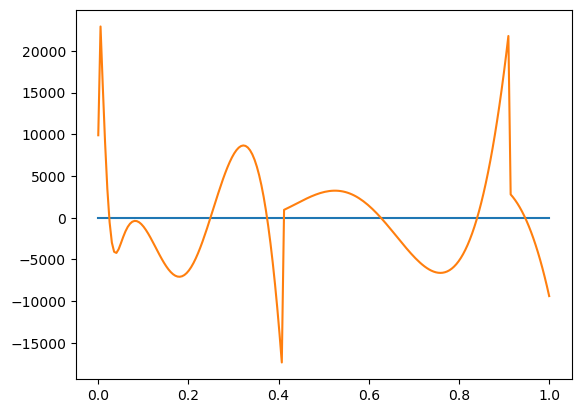

In [199]:

plt.plot(np.linspace(0,1,200), Xtr[0])

plt.plot(np.linspace(0,1,200), Ytr[0])

In [65]:
Xtr[0]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1

In [108]:
m = 200
n = 200

def cplx(p):
    return min(2*m*n, (2*p-1)*n + (2*m-1)*p + m)

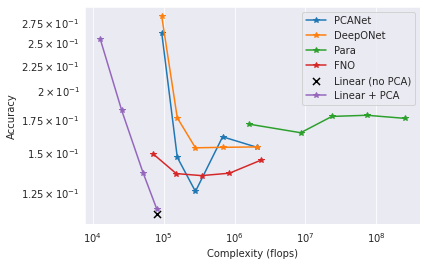

In [129]:
plt.xlabel('Complexity (flops)')
plt.ylabel('Accuracy')
plt.plot(PCANet[PCANet[:,0] == 20000][:,2], PCANet[PCANet[:,0] == 20000][:, 4], '-*', label = 'PCANet')
plt.plot(DeepONet[DeepONet[:,0] == 20000][:,2], DeepONet[DeepONet[:,0] == 20000][:, 4], '-*', label = 'DeepONet')
plt.plot(Para[Para[:,0] == 20000][:,2], Para[Para[:,0] == 20000][:, 4], '-*', label = 'Para')
plt.plot(FNO[FNO[:,0] == 20000][:,2], FNO[FNO[:,0] == 20000][:, 4], '-*', label = 'FNO')
plt.scatter([2*m*n], [results[:, 2][-1]], marker = 'x', s = 50, color = 'black', label = 'Linear (no PCA)')
plt.plot([cplx(i) for i in [j[0] for j in resultspca]], [i[1] for i in resultspca], '-*', label = 'Linear + PCA')
plt.legend()
plt.xscale('log')
plt.yscale('log')

In [ ]:
result

In [127]:
resultspca = []
for Ntrain in [20000]:
    for N_components in [16, 32, 64, 128]:
        print(Ntrain)
        Ytr = Outputs.T[:Ntrain]
        Xtr = Inputs.T[:Ntrain]
        pca = PCA(n_components=min(N_components,Ntrain))
        Xtr = pca.fit_transform(Xtr)
        reg = LinearRegression(n_jobs = -1).fit(Xtr, Ytr)
        #Ypred Ypredtr = reg.predict(Xtr)
        Ypredtr = reg.predict(Xtr)
        train_error = np.mean(np.linalg.norm(Ypredtr-Ytr, axis = 1)/np.linalg.norm(Ytr, axis = 1))
        Xtest = Inputs.T[20000:]
        Ytest = Outputs.T[20000:]
        Xtest = pca.transform(Xtest)
        Ypred = reg.predict(Xtest)
        test_error = np.mean(np.linalg.norm(Ypred-Ytest, axis = 1)/np.linalg.norm(Ytest, axis = 1))
        print(N_components, train_error, test_error)
        resultspca.append([N_components, test_error])
#results = np.array(results)

20000
16 0.25345924979376705 0.25382912737449226
20000
32 0.18202578074587858 0.18260966609046456
20000
64 0.1362008796264501 0.13676614365383558
20000
128 0.11471092808787887 0.1154622012396907
